In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
GSPC.isnull().sum().sort_values(ascending = False)

              Adj Close
Date                   
2017-01-03  2257.830078
2017-01-04  2270.750000
2017-01-05  2269.000000
2017-01-06  2276.979980
2017-01-09  2268.899902
...                 ...
2018-12-24  2351.100098
2018-12-26  2467.699951
2018-12-27  2488.830078
2018-12-28  2485.739990
2018-12-31  2506.850098

[502 rows x 1 columns]


Adj Close    0
dtype: int64

In [4]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [5]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data,percentage=0.5,size=10,emdtype=EMD,emdsum=1):
    data_pure = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        temp=emd_calculate(data[i-window:i],plots=False,emdtype=emdtype)
        temp_1= reconstruction(temp)
        data_pure= pd.concat([data_pure,pd.Series(temp_1.values[emdsum,:])], axis=1)
    return data_pure.T

In [7]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [8]:
GSPC_pure=create_pure(GSPC,emdsum=0)

GSPC_noisy=create_noisy(GSPC)

In [9]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(26, 251)
(26, 251)


In [10]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [11]:
keras.backend.clear_session()

In [16]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 128)         512       
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-trai

In [17]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
1/1 [==============================] - 1s 765ms/step - loss: 0.0695 - mae: 0.2252 - val_loss: 0.0625 - val_mae: 0.2086
Epoch 2/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0681 - mae: 0.2228 - val_loss: 0.0611 - val_mae: 0.2064
Epoch 3/400
1/1 [==============================] - 0s 38ms/step - loss: 0.0671 - mae: 0.2211 - val_loss: 0.0596 - val_mae: 0.2039
Epoch 4/400
1/1 [==============================] - 0s 36ms/step - loss: 0.0659 - mae: 0.2190 - val_loss: 0.0580 - val_mae: 0.2014
Epoch 5/400
1/1 [==============================] - 0s 38ms/step - loss: 0.0646 - mae: 0.2168 - val_loss: 0.0562 - val_mae: 0.1983
Epoch 6/400
1/1 [==============================] - 0s 39ms/step - loss: 0.0630 - mae: 0.2141 - val_loss: 0.0540 - val_mae: 0.1945
Epoch 7/400
1/1 [==============================] - 0s 38ms/step - loss: 0.0612 - mae: 0.2107 - val_loss: 0.0514 - val_mae: 0.1900
Epoch 8/400
1/1 [==============================] - 0s 36ms/step - loss: 0.0590 - mae: 0.2

In [117]:
modelen_mm.load_weights('model_weights_mmlater.h5')  

In [19]:
modelen_mm.save_weights('model_weights_mmlater.h5', overwrite=True)  

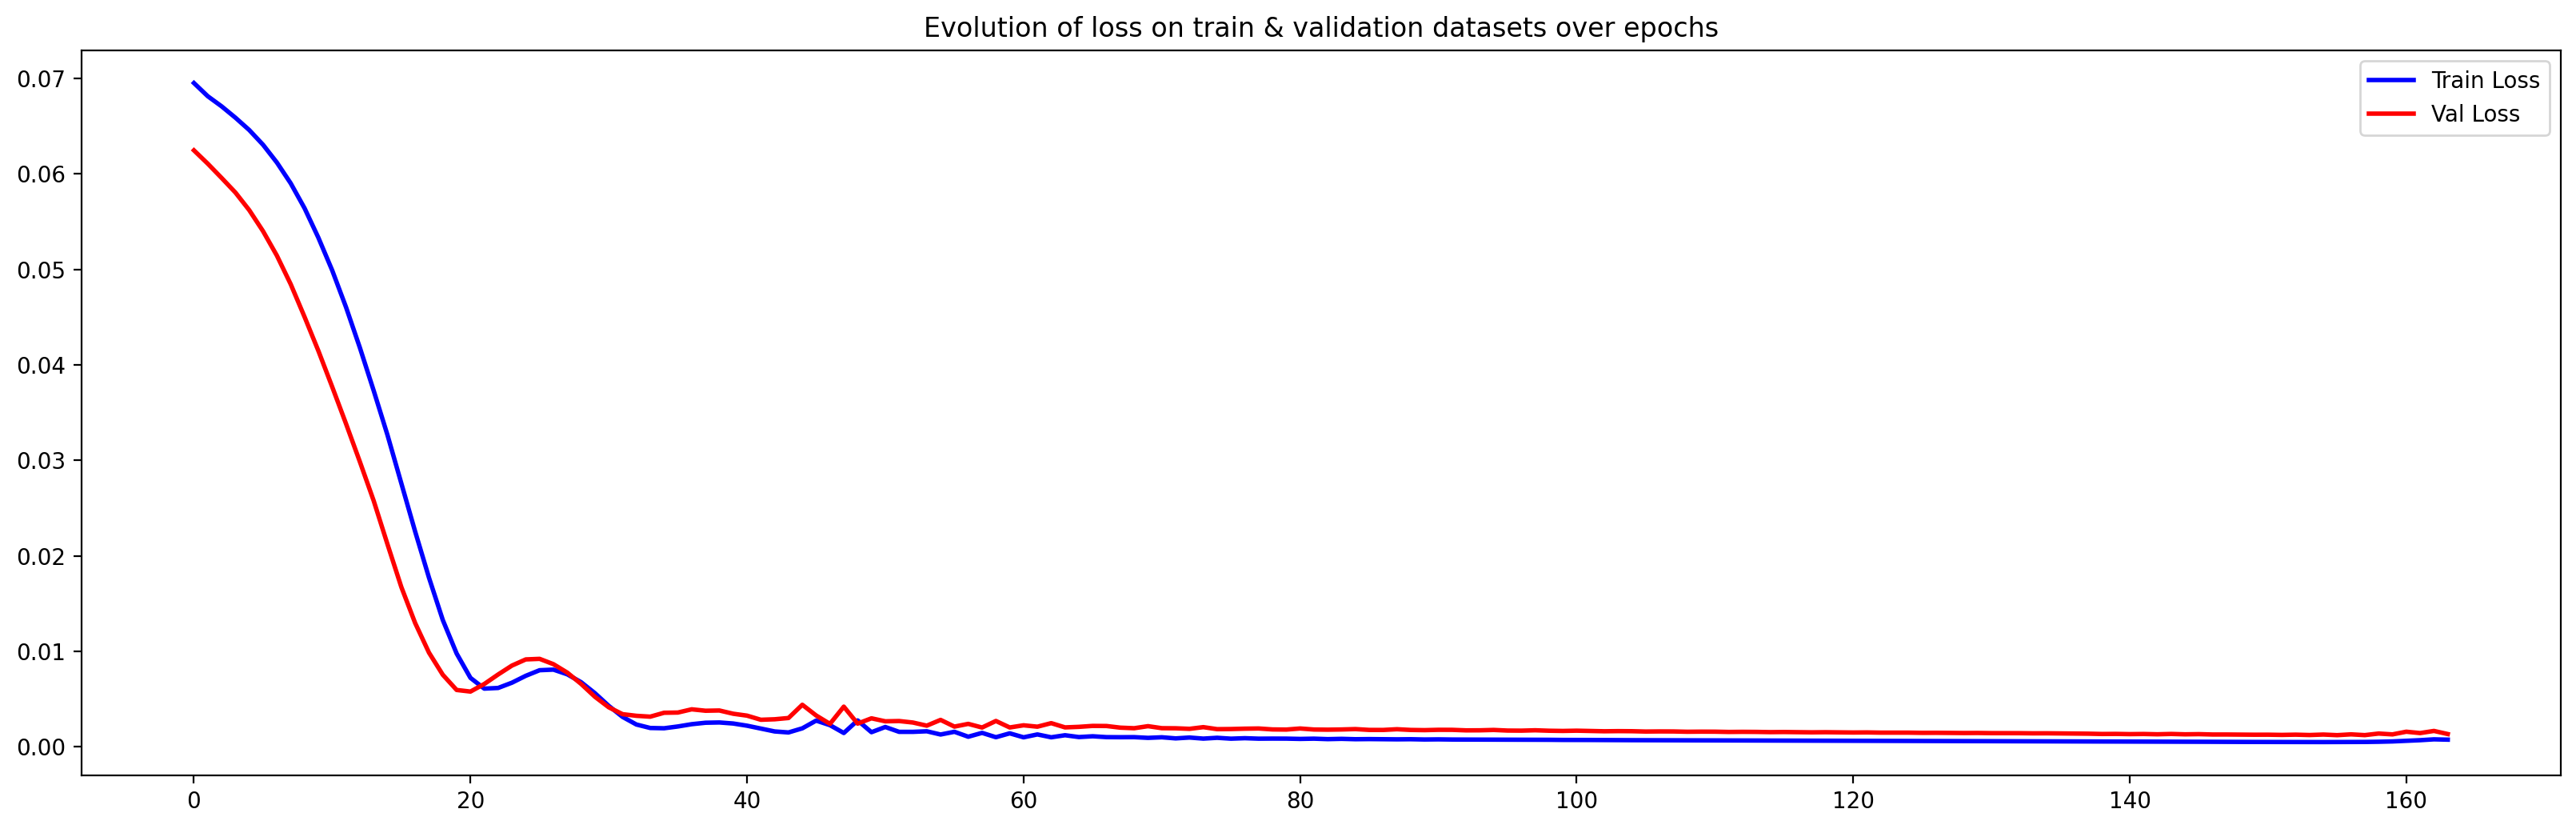

In [18]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [19]:
start = '2018-06-01'
end = '2019-06-01'
GSPC_test = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

,Adj Close
Date,
2018-06-01,2734.620117
2018-06-04,2746.870117
2018-06-05,2748.800049
2018-06-06,2772.350098
2018-06-07,2770.370117
...,...
2019-05-24,2826.060059
2019-05-28,2802.389893
2019-05-29,2783.020020


1/1 [==============================] - 0s 112ms/step


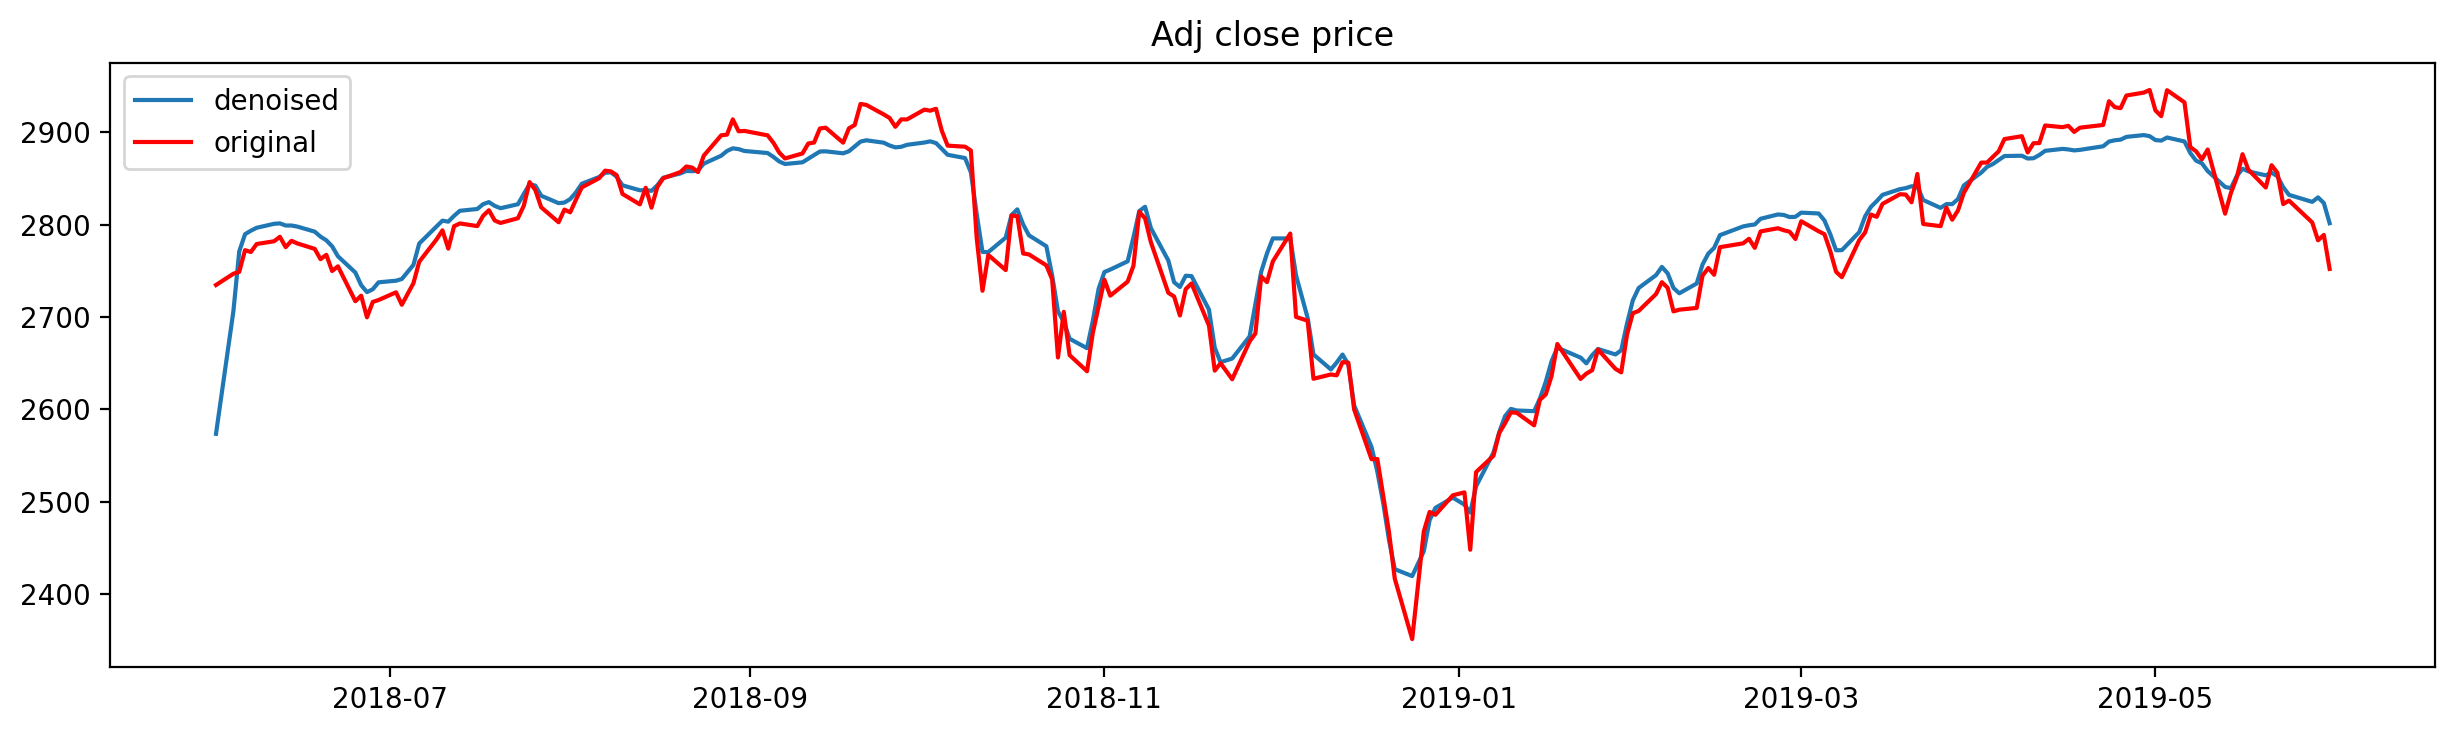

In [20]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

In [21]:
original=GSPC_test
recon=pure_mm_cnn

In [22]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [23]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

788.6231533355183
23803.924277875158
3437.938088426987
20014.997223036156
11100.269080443515
1456.4536440173786
1836.2374023927582
2489.1073704361916
649.229339496957
1090.9473482635285
The last MSE: 1090.9473482635285
The average MSE: 6666.7726927724125


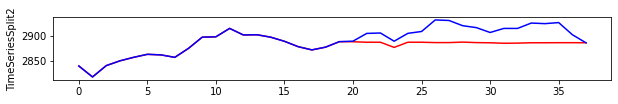

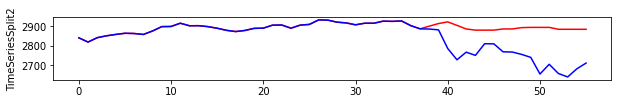

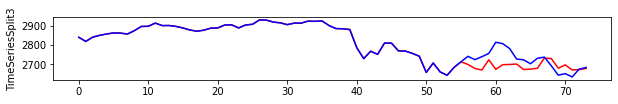

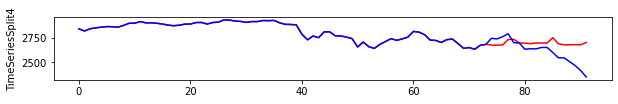

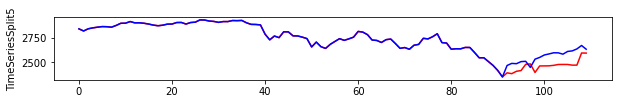

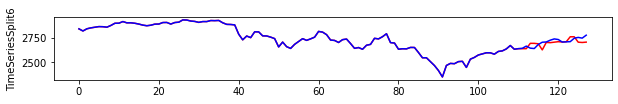

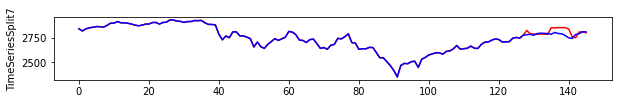

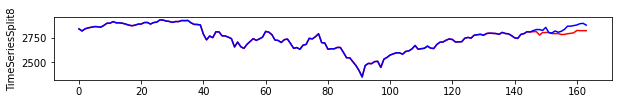

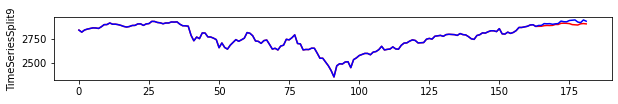

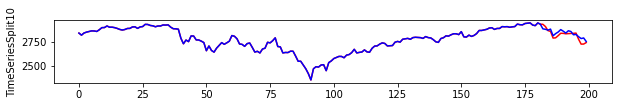

In [24]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [20]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
parameters = {  'max_depth': [1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
  'n_estimators': [ 200, 300, 500, 700]}  # Specify the range of hyperparameters in the model to reduce time spent

In [21]:
# In the following we pass the data into the grid search model and output the hyperparameter optimal values.
reg = xgb.XGBRegressor(eval_metric=mean_squared_error)  # Building the model
grid_search = HalvingGridSearchCV(reg, parameters, scoring='neg_mean_squared_error',verbose=1,cv=None) 
grid_search.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])  # Input data
print("Optimal values for hyperparameters:",grid_search.best_params_)
print("Best model score:",grid_search.best_score_)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 10
max_resources_: 182
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 10
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 30
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 90
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal values for hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 700}
Best model score: -2873.987590862372


In [22]:
model = xgb.XGBRegressor(
                        n_estimators=700,
                        max_depth=10,
                        learning_rate=0.1,)
model.fit (recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(recon_fea.iloc[test_index,:])
msetest=mean_squared_error(recon_m.iloc[test_index,:],test_predict)
msetest

755.9846

In [23]:
parameters = {  'max_depth':[1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [ 100,200, 300, 500, 700],
    'min_child_weight': [0, 2, 5, 10, 20],
    #'max_delta_step': [0, 0.2, 0.6, 1, 2],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
    'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1],
    'gamma':[0,0.01,0.05,0.1,0.2,0.4,0.6]}  # Specify the range of hyperparameters in the model to reduce time spent

In [24]:
regran = xgb.XGBRegressor(eval_metric=mean_squared_error)  
Rgrid_search = HalvingRandomSearchCV(regran, parameters, scoring='neg_mean_squared_error', verbose=1,cv=None) 
Rgrid_search.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:]) 
print("Optimal values for hyperparameters:",Rgrid_search.best_params_)
print("Best model score:",Rgrid_search.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 10
max_resources_: 182
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 10
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 6
n_resources: 30
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 90
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal values for hyperparameters: {'subsample': 0.6, 'scale_pos_weight': 0.8, 'reg_lambda': 0.4, 'reg_alpha': 0.25, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best model score: -4261.291451234443


In [25]:
model = xgb.XGBRegressor(subsample=0.6,
                        scale_pos_weight=0.8,
                        reg_lambda=0.4,
                        reg_alpha=0.25,
                        n_estimators=500,
                        min_child_weight=2,
                        max_depth=10,
                        learning_rate=0.1,
                        gamma=0.1,
                        colsample_bytree=0.5)
model.fit (recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(recon_fea.iloc[test_index,:])
msetest=mean_squared_error(recon_m.iloc[test_index,:],test_predict)
msetest

422.973

In [25]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [27]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.304e+0 |  0.5722   |  0.09972  |  0.1971   |  13.03    |  0.04294  |  226.6    |  0.423    |  0.7286   |  0.2238   |  0.529    |
|  2        | -1.338e+0 |  0.935    |  0.2921   |  0.282    |  9.92     |  0.004294 |  352.4    |  0.4771   |  0.972    |  0.5743   |  0.5506   |
|  3        | -3.531e+0 |  0.8289   |  0.2904   |  0.2775   |  13.65    |  0.6677   |  264.8    |  0.7426   |  0.545    |  0.3296   |  0.7399   |
|  4        | -943.9    |  0.965    |  0.3314   |  0.01276  |  13.07    |  1.244    |  738.5    |  0.3993   |  0.4633   |  0.9643   |  0.6108   |
|  5        | -1.16e+03 |  0.536    |  0.08466  |  0.1269   |  1.854    |  0.9035   |  655.8    |  0.1277   |  0.2075   |  0

{'target': -437.190185546875,
 'params': {'colsample_bytree': 0.6713924709034975,
  'gamma': 0.6905102723576256,
  'learning_rate': 0.24133553063155697,
  'max_depth': 17,
  'min_child_weight': 2,
  'n_estimators': 395,
  'reg_alpha': 0.9793785495820753,
  'reg_lambda': 0.873002111345274,
  'scale_pos_weight': 0.467947479027149,
  'subsample': 0.8233664968188946}}

The last MSE: 1896.106842233075
The average MSE: 6788.943680778806


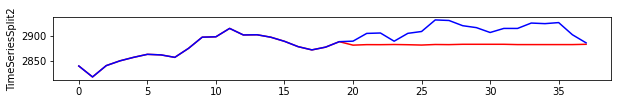

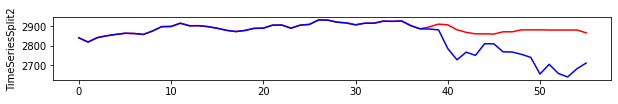

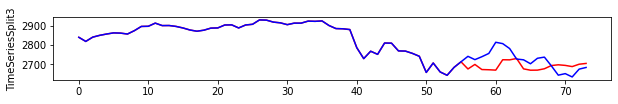

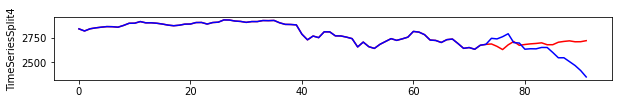

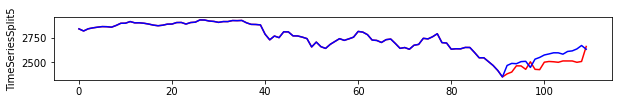

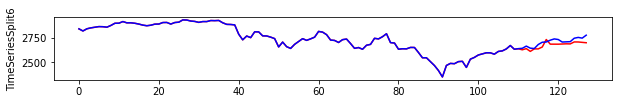

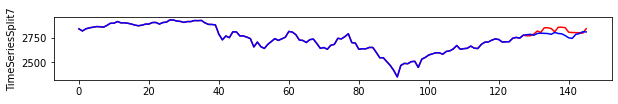

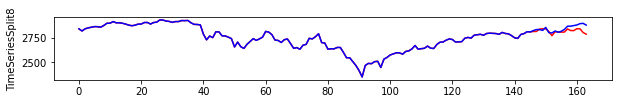

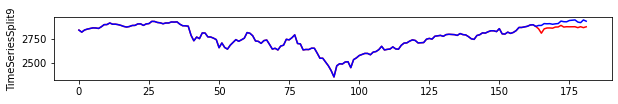

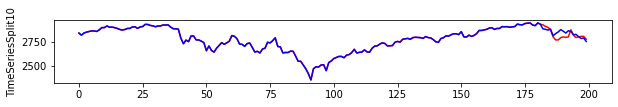

In [124]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [108]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
parameters = {  'max_depth': [1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
  'n_estimators': [ 200, 300, 500, 700]}  # Specify the range of hyperparameters in the model to reduce time spent

In [109]:
# In the following we pass the data into the grid search model and output the hyperparameter optimal values.
reg = xgb.XGBRegressor(eval_metric=mean_squared_error)  # Building the model
grid_search = HalvingGridSearchCV(reg, parameters, scoring='neg_mean_squared_error',verbose=1,cv=None) 
grid_search.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])  # Input data
print("Optimal values for hyperparameters:",grid_search.best_params_)
print("Best model score:",grid_search.best_score_)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 10
max_resources_: 182
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 10
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 30
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 90
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal values for hyperparameters: {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 700}
Best model score: -5114.213177644038


In [110]:
model = xgb.XGBRegressor(
                        n_estimators=700,
                        max_depth=10,
                        learning_rate=0.02,)
model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(original_fea.iloc[test_index,:])
msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
msetest

2094.160648379061

In [111]:
parameters = {  'max_depth':[1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [ 100,200, 300, 500, 700],
    'min_child_weight': [0, 2, 5, 10, 20],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
    'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1],
    'gamma':[0,0.01,0.05,0.1,0.2,0.4,0.6]}  # Specify the range of hyperparameters in the model to reduce time spent

In [112]:
regran = xgb.XGBRegressor(eval_metric=mean_squared_error)  
Rgrid_search = HalvingRandomSearchCV(regran, parameters, scoring='neg_mean_squared_error', verbose=1,cv=None) 
Rgrid_search.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:]) 
print("Optimal values for hyperparameters:",Rgrid_search.best_params_)
print("Best model score:",Rgrid_search.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 10
max_resources_: 182
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 10
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 6
n_resources: 30
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 90
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal values for hyperparameters: {'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 0.8, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 0, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}
Best model score: -3981.967834908588


In [113]:
model = xgb.XGBRegressor(subsample=0.6,
                        scale_pos_weight=1,
                        reg_lambda=0.8,
                        reg_alpha=1,
                        n_estimators=500,
                        min_child_weight=0,
                        max_depth=10,
                        learning_rate=0.05,
                        gamma=0,
                        colsample_bytree=0.5)
model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(original_fea.iloc[test_index,:])
msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
msetest

1422.358187529776

In [114]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [116]:
rf_bo = BayesianOptimization(
        rf_oo,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.451e+0 |  0.9469   |  0.5459   |  0.06225  |  15.28    |  0.7525   |  108.5    |  0.649    |  0.2431   |  0.3944   |  0.5138   |
|  2        | -1.524e+0 |  0.636    |  0.8746   |  0.1526   |  3.739    |  0.4465   |  457.4    |  0.1674   |  0.4031   |  0.6285   |  0.7156   |
|  3        | -1.04e+03 |  0.6901   |  0.5835   |  0.1522   |  3.744    |  0.7032   |  387.0    |  0.7974   |  0.4135   |  0.6692   |  0.7698   |
|  4        | -1.338e+0 |  0.8609   |  0.1793   |  0.09003  |  1.618    |  1.006    |  187.2    |  0.2606   |  0.4769   |  0.2604   |  0.7448   |
|  5        | -1.708e+0 |  0.9368   |  0.3789   |  0.2758   |  8.202    |  1.683    |  888.8    |  0.5592   |  0.2233   |  0

{'target': -666.5796529948711,
 'params': {'colsample_bytree': 0.5250287182075064,
  'gamma': 0.6655244762077236,
  'learning_rate': 0.07101117325014994,
  'max_depth': 4,
  'min_child_weight': 1,
  'n_estimators': 387,
  'reg_alpha': 0.6685442084355148,
  'reg_lambda': 0.6611826348816195,
  'scale_pos_weight': 0.7809207853396569,
  'subsample': 0.9781067769114447}}

# EMDCNN

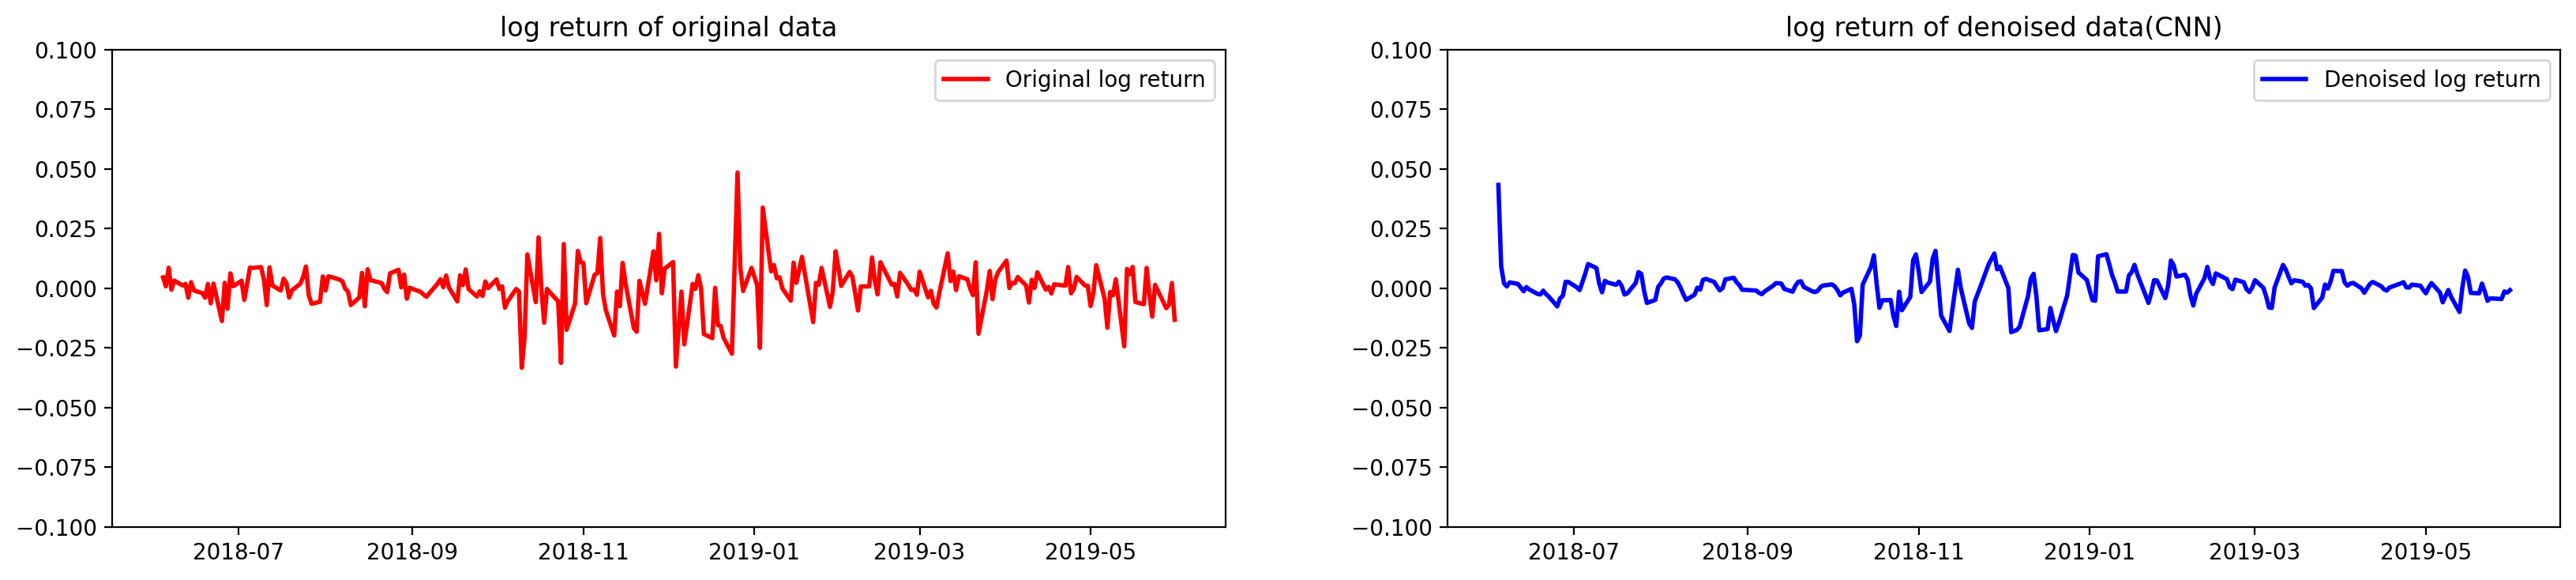

In [125]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [32]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/100):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/100):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [33]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

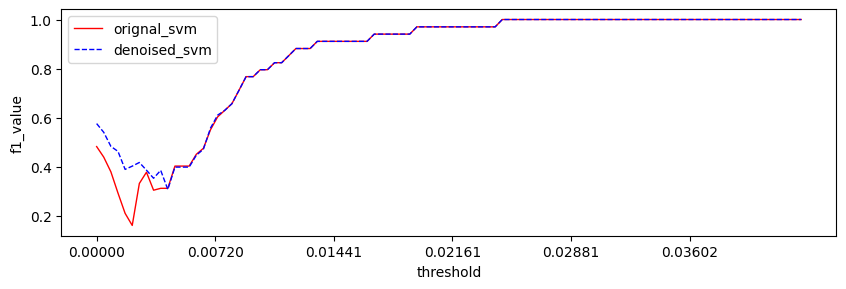

In [34]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Strategies 

## Bollinger band

In [129]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [130]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [131]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [132]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
  1.0    8
-1.0    4
Name: signal, dtype: int64 

pure_mm_cnn_signal:
  1.0    3
-1.0    1
Name: signal, dtype: int64 



In [133]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2018-06-25  2717.070068
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
2019-05-13  2811.870117
2019-05-31  2752.060059
              Adj Close
Date                   
2018-10-09  2880.340088
2018-12-19  2506.959961
2019-05-09  2870.719971


In [134]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2018-08-27  2896.739990
2018-09-20  2930.750000
2019-03-18  2832.939941
2019-03-21  2854.879883
             Adj Close
Date                  
2018-08-28  2897.52002


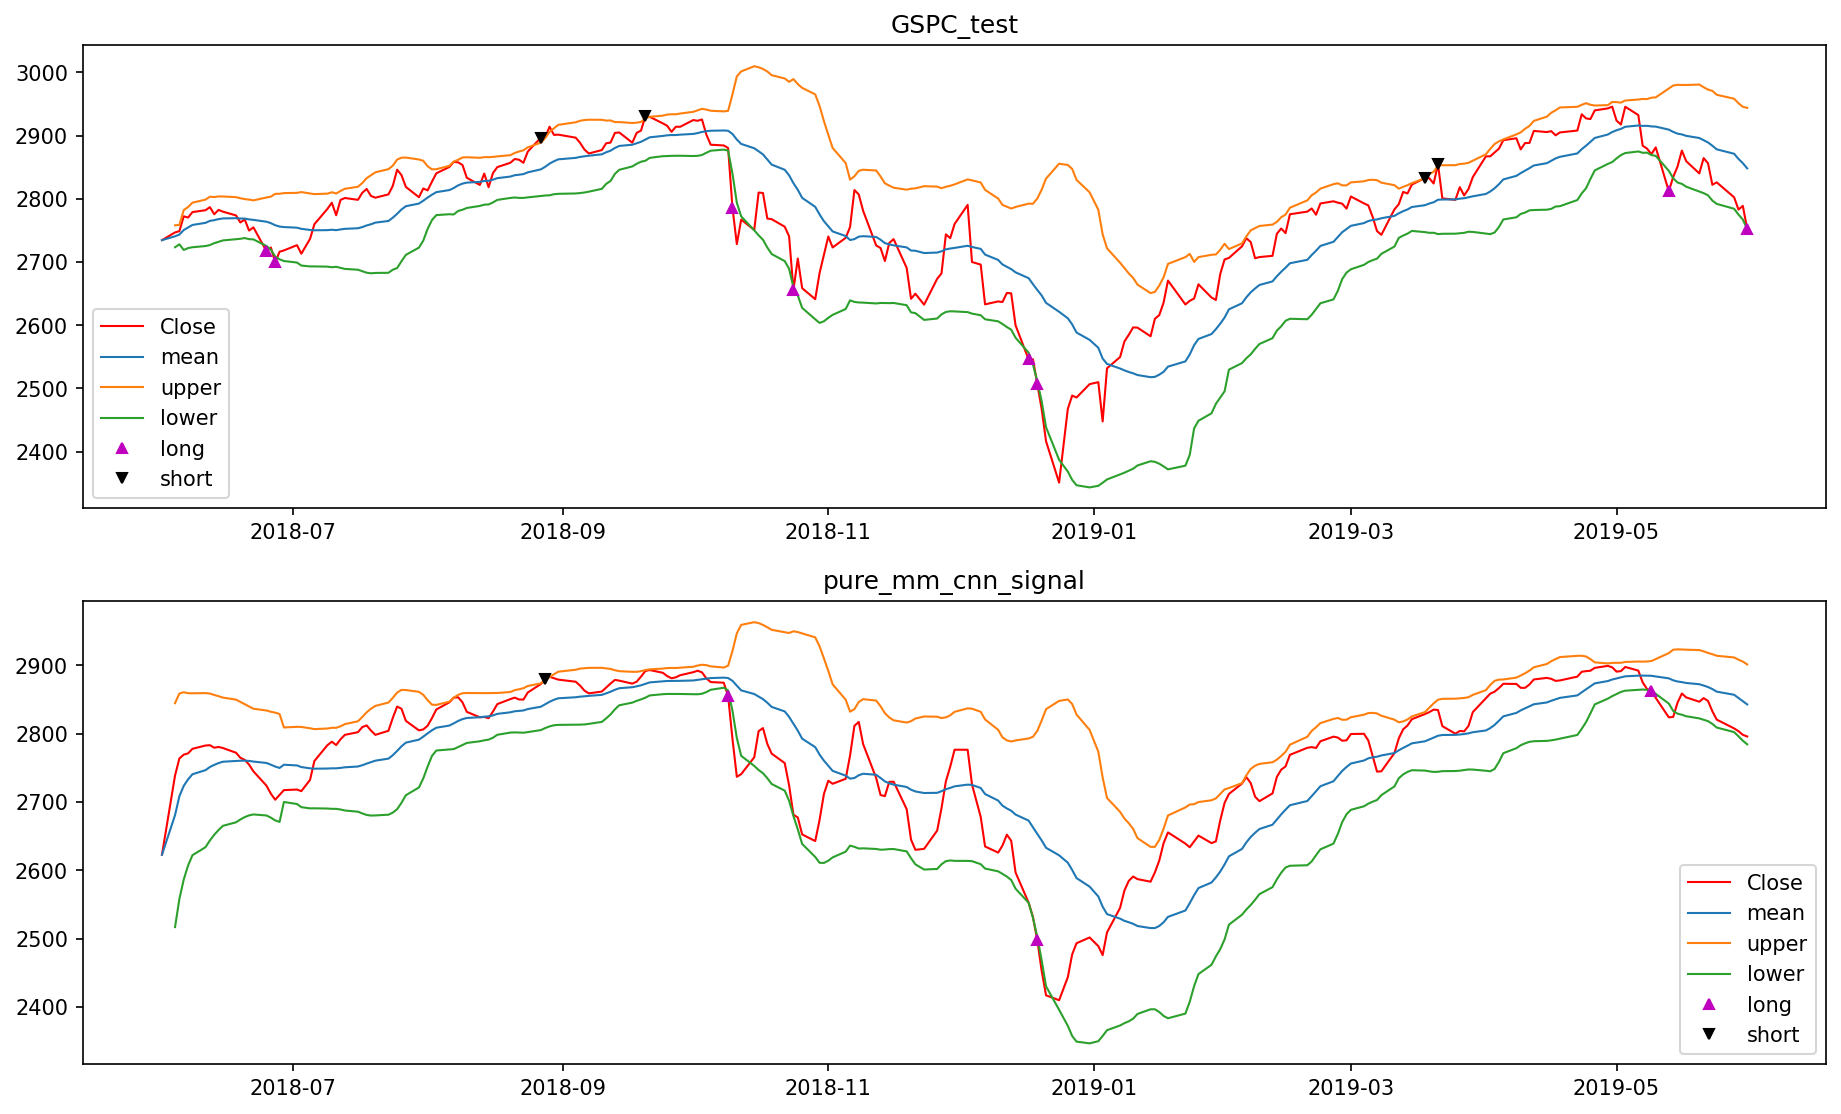

In [135]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [136]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

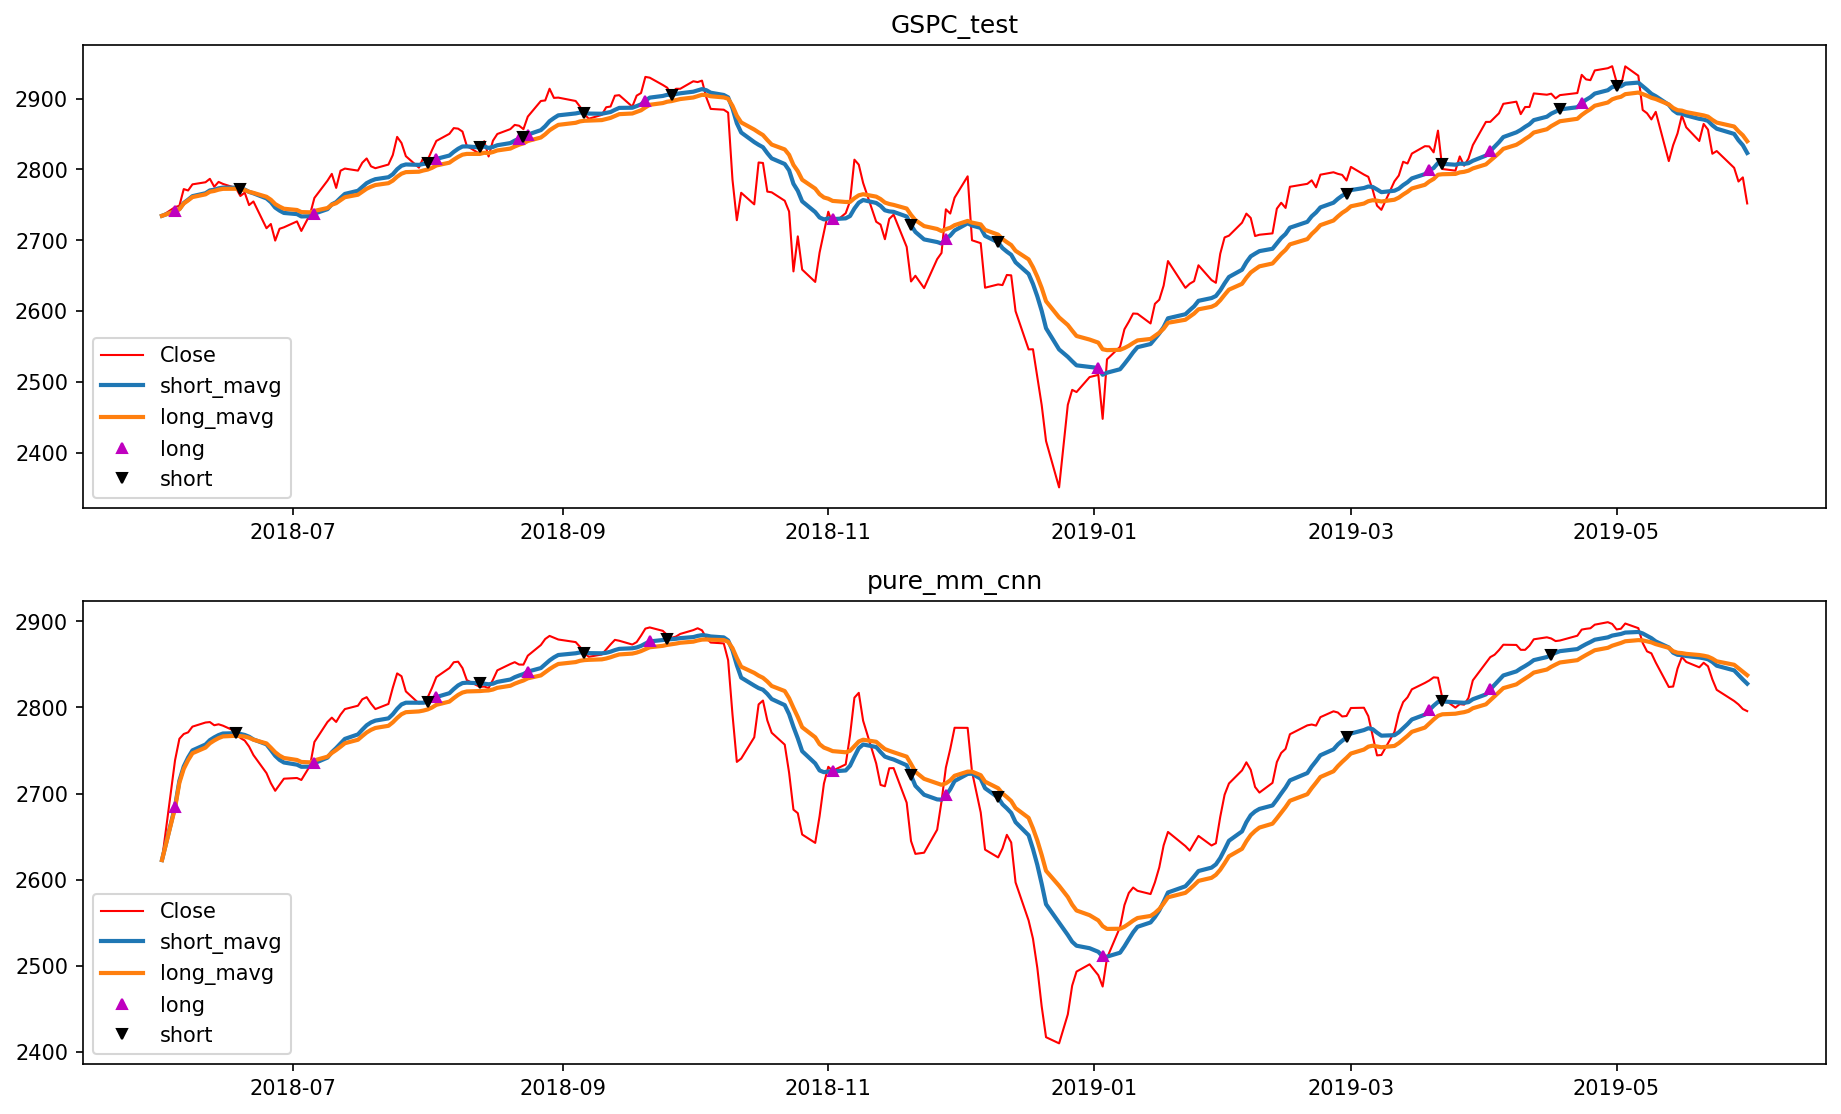

In [137]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [138]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    226
 1.0     12
-1.0     12
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    230
 1.0     10
-1.0     10
Name: positions, dtype: int64 



In [140]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2018-06-04  2746.870117
2018-07-06  2759.820068
2018-08-03  2840.350098
2018-08-22  2861.820068
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-02  2510.030029
2019-03-19  2832.570068
2019-04-02  2867.239990
2019-04-23  2933.679932
              Adj Close
Date                   
2018-06-04  2746.870117
2018-07-06  2759.820068
2018-08-03  2840.350098
2018-08-24  2874.689941
2018-09-21  2929.669922
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-03  2447.889893
2019-03-19  2832.570068
2019-04-02  2867.239990


In [141]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2018-06-19  2762.590088
2018-08-01  2813.360107
2018-08-13  2821.929932
2018-08-23  2856.979980
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-28  2784.489990
2019-03-22  2800.709961
2019-04-18  2905.030029
2019-05-01  2923.729980
              Adj Close
Date                   
2018-06-18  2773.750000
2018-08-01  2813.360107
2018-08-13  2821.929932
2018-09-06  2878.050049
2018-09-25  2915.560059
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-28  2784.489990
2019-03-22  2800.709961
2019-04-16  2907.060059


## MA

In [142]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

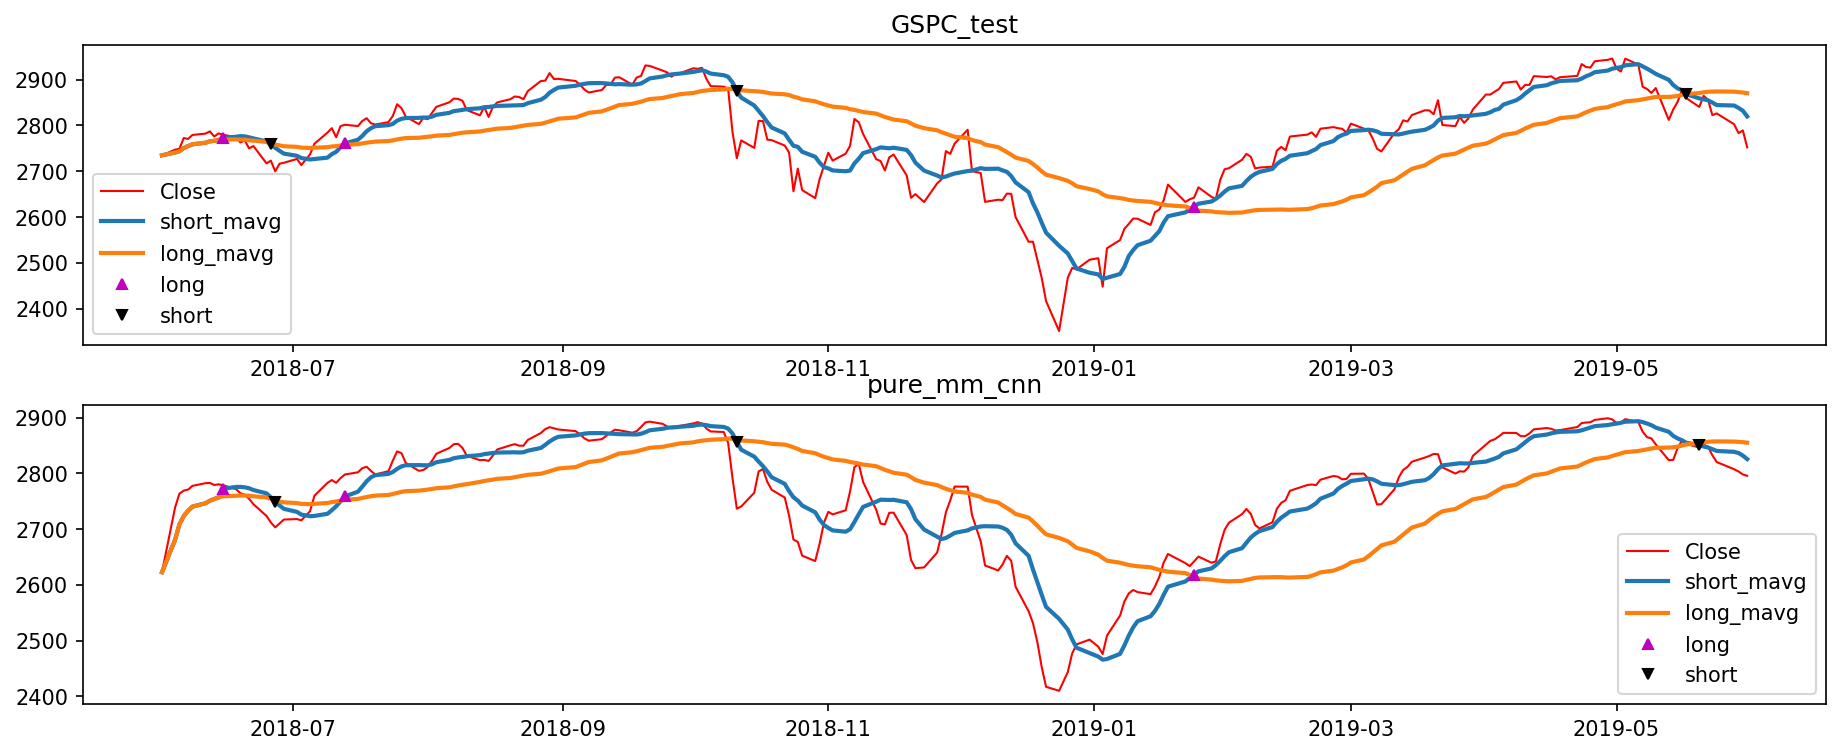

In [143]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [144]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    244
 1.0      3
-1.0      3
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    244
 1.0      3
-1.0      3
Name: positions, dtype: int64 



In [145]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2018-06-15  2779.659912
2018-07-13  2801.310059
2019-01-24  2642.330078
              Adj Close
Date                   
2018-06-15  2779.659912
2018-07-13  2801.310059
2019-01-24  2642.330078


In [51]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2018-06-26  2723.060059
2018-10-11  2728.370117
2019-05-17  2859.530029
              Adj Close
Date                   
2018-06-27  2699.629883
2018-10-11  2728.370117
2019-05-20  2840.229980


## Strategies backtest

In [52]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [53]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [54]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [55]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.03263379541015625
0.016880164794921874


In [56]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
#print(mareturn_lstm)

0.04291489184570312
0.083659123046875


In [57]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)


0.061144982421875
-0.04451317016601562


# Only emd

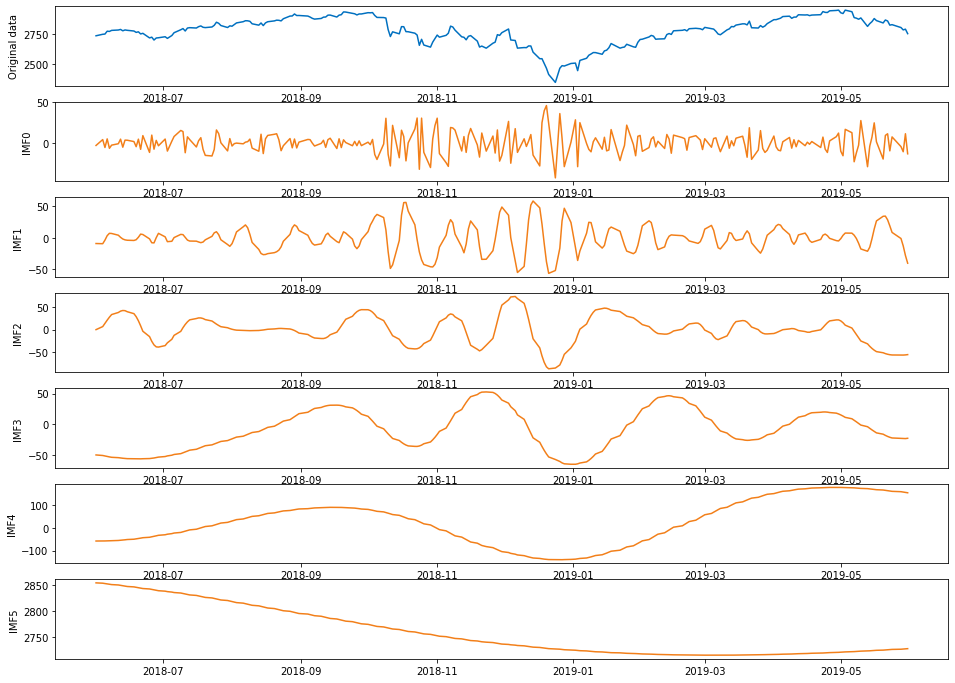

In [146]:
emdre=emd_calculate(GSPC_test)
reedm=reconstruction(emdre)

In [147]:
pure_mm_cnn=pd.DataFrame(reedm.iloc[1,:]).rename(columns={'sum1':'Adj Close'})
pure_mm_cnn

,Adj Close
Date,
2018-06-01,2737.099396
2018-06-04,2742.196722
2018-06-05,2753.754986
2018-06-06,2766.825349
2018-06-07,2776.308263
...,...
2019-05-24,2818.127094
2019-05-28,2806.287141
2019-05-29,2793.139232


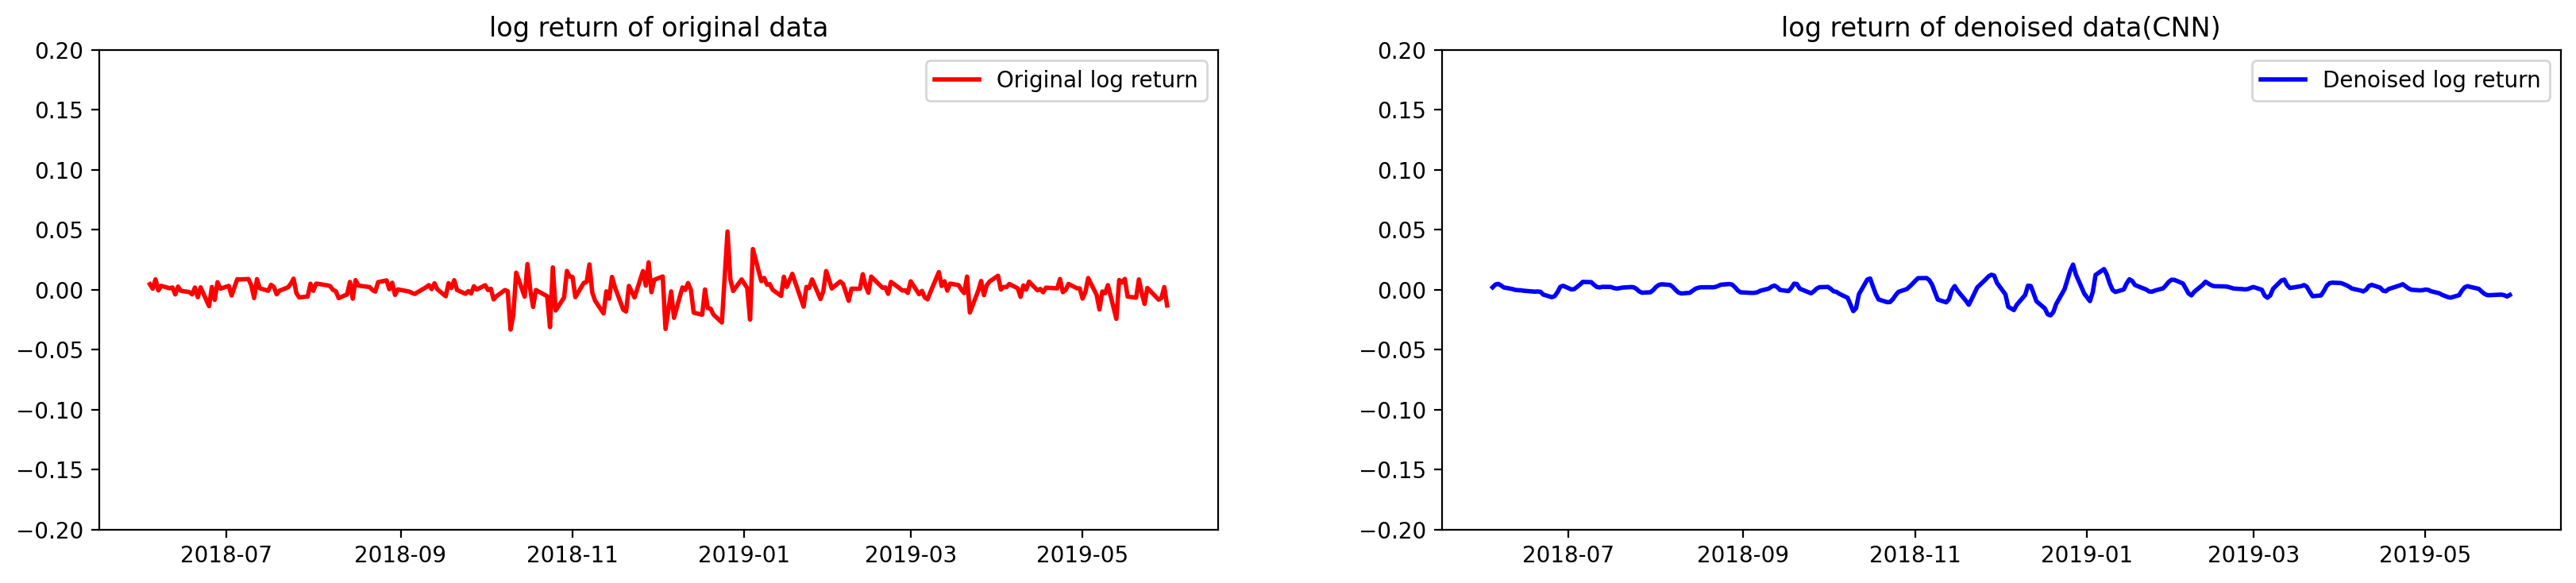

In [148]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [149]:
original=pd.DataFrame(GSPC_test['Adj Close'])
recon=pd.DataFrame(pure_mm_cnn['Adj Close'])

In [150]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [151]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

1067.3863187001812
18756.494846337373
3154.2294611103007
18494.587710761363
11201.449254436626
945.2297269602617
895.3407976064417
1517.8915586305989
1618.0559349225628
605.3924884630574
The last MSE: 605.3924884630574
The average MSE: 5825.605809792876


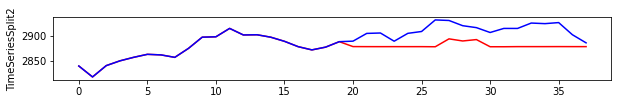

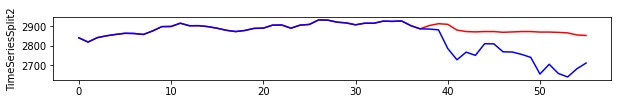

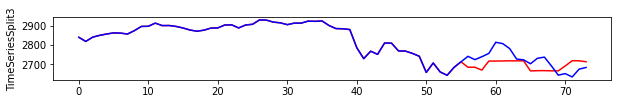

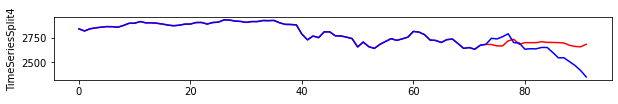

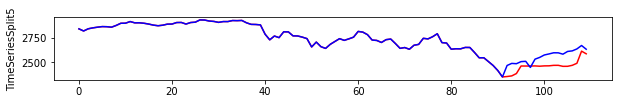

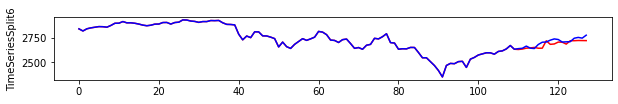

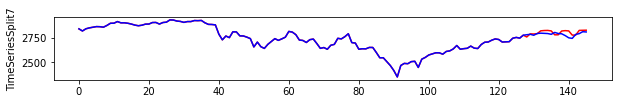

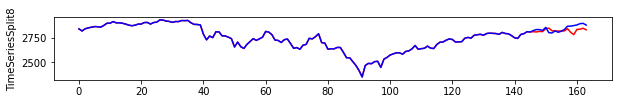

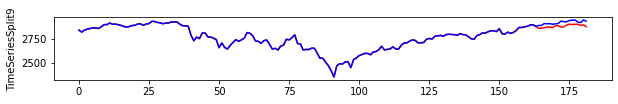

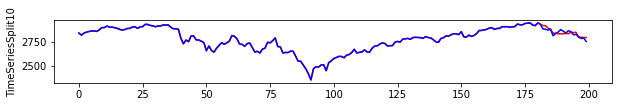

In [152]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [153]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [154]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.394e+0 |  0.6406   |  0.7449   |  0.2246   |  17.67    |  0.5315   |  211.8    |  0.8343   |  0.4504   |  0.6952   |  0.6958   |
|  2        | -545.4    |  0.7634   |  0.9261   |  0.2504   |  10.72    |  0.1574   |  297.2    |  0.2587   |  0.4137   |  0.6985   |  0.704    |
|  3        | -1.182e+0 |  0.9839   |  0.2902   |  0.01781  |  17.43    |  1.51     |  275.9    |  0.8783   |  0.6515   |  0.4812   |  0.9302   |
|  4        | -1.131e+0 |  0.6003   |  0.6685   |  0.158    |  15.12    |  0.3505   |  345.7    |  0.2362   |  0.5553   |  0.8358   |  0.5101   |
|  5        | -670.5    |  0.8724   |  0.965    |  0.13     |  9.621    |  0.4363   |  800.4    |  0.2912   |  0.421    |  0

{'target': -453.30831962702814,
 'params': {'colsample_bytree': 1.0,
  'gamma': 0.0,
  'learning_rate': 0.01,
  'max_depth': 15,
  'min_child_weight': 2,
  'n_estimators': 533,
  'reg_alpha': 0.01,
  'reg_lambda': 1.0,
  'scale_pos_weight': 0.2,
  'subsample': 0.5}}

The last MSE: 1896.106842233075
The average MSE: 6788.943680778806


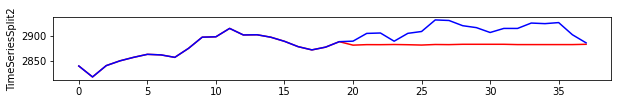

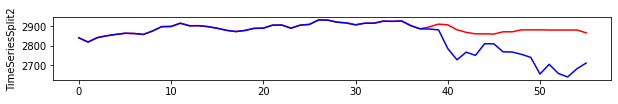

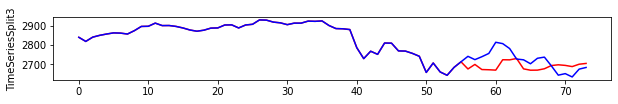

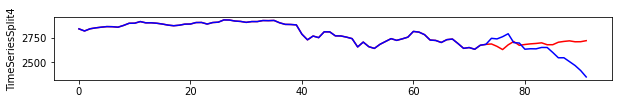

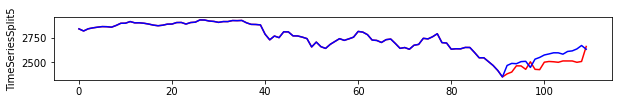

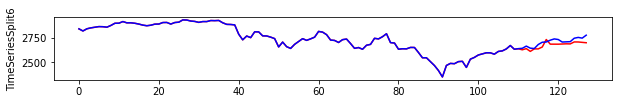

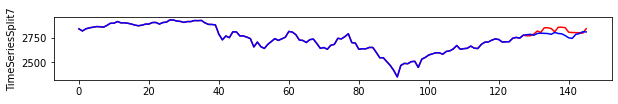

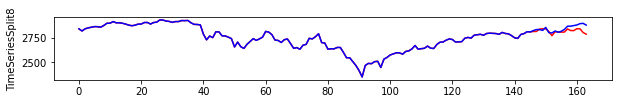

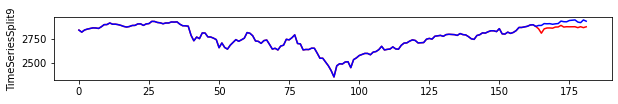

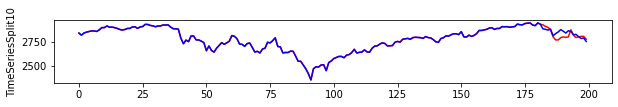

In [71]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [72]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/100):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/100):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [73]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1)

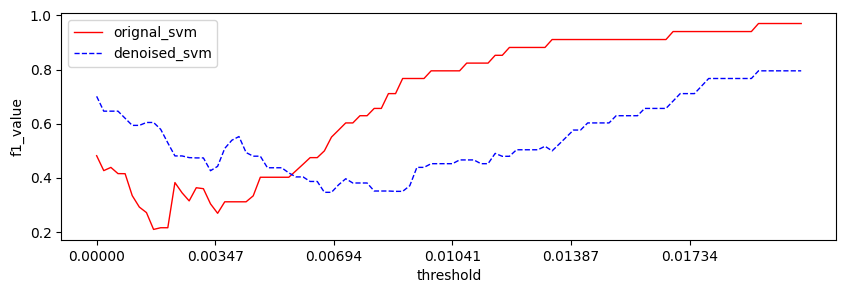

In [74]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Strategies 

## Bollinger band

In [75]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [76]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [77]:
pure_mm_cnn

,Adj Close,log_ret
Date,,
2018-06-01,2737.099396,NaN
2018-06-04,2742.196722,0.001861
2018-06-05,2753.754986,0.004206
2018-06-06,2766.825349,0.004735
2018-06-07,2776.308263,0.003422
...,...,...
2019-05-24,2818.127094,-0.004664
2019-05-28,2806.287141,-0.004210
2019-05-29,2793.139232,-0.004696


In [78]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [79]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
  1.0    8
-1.0    4
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    5
 1.0    4
Name: signal, dtype: int64 



In [80]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2018-06-25  2717.070068
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
2019-05-13  2811.870117
2019-05-31  2752.060059
              Adj Close
Date                   
2018-06-25  2717.070068
2018-10-09  2880.340088
2018-12-18  2546.159912
2019-05-09  2870.719971


In [81]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2018-08-27  2896.739990
2018-09-20  2930.750000
2019-03-18  2832.939941
2019-03-21  2854.879883
              Adj Close
Date                   
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2019-02-04  2724.870117
2019-03-19  2832.570068


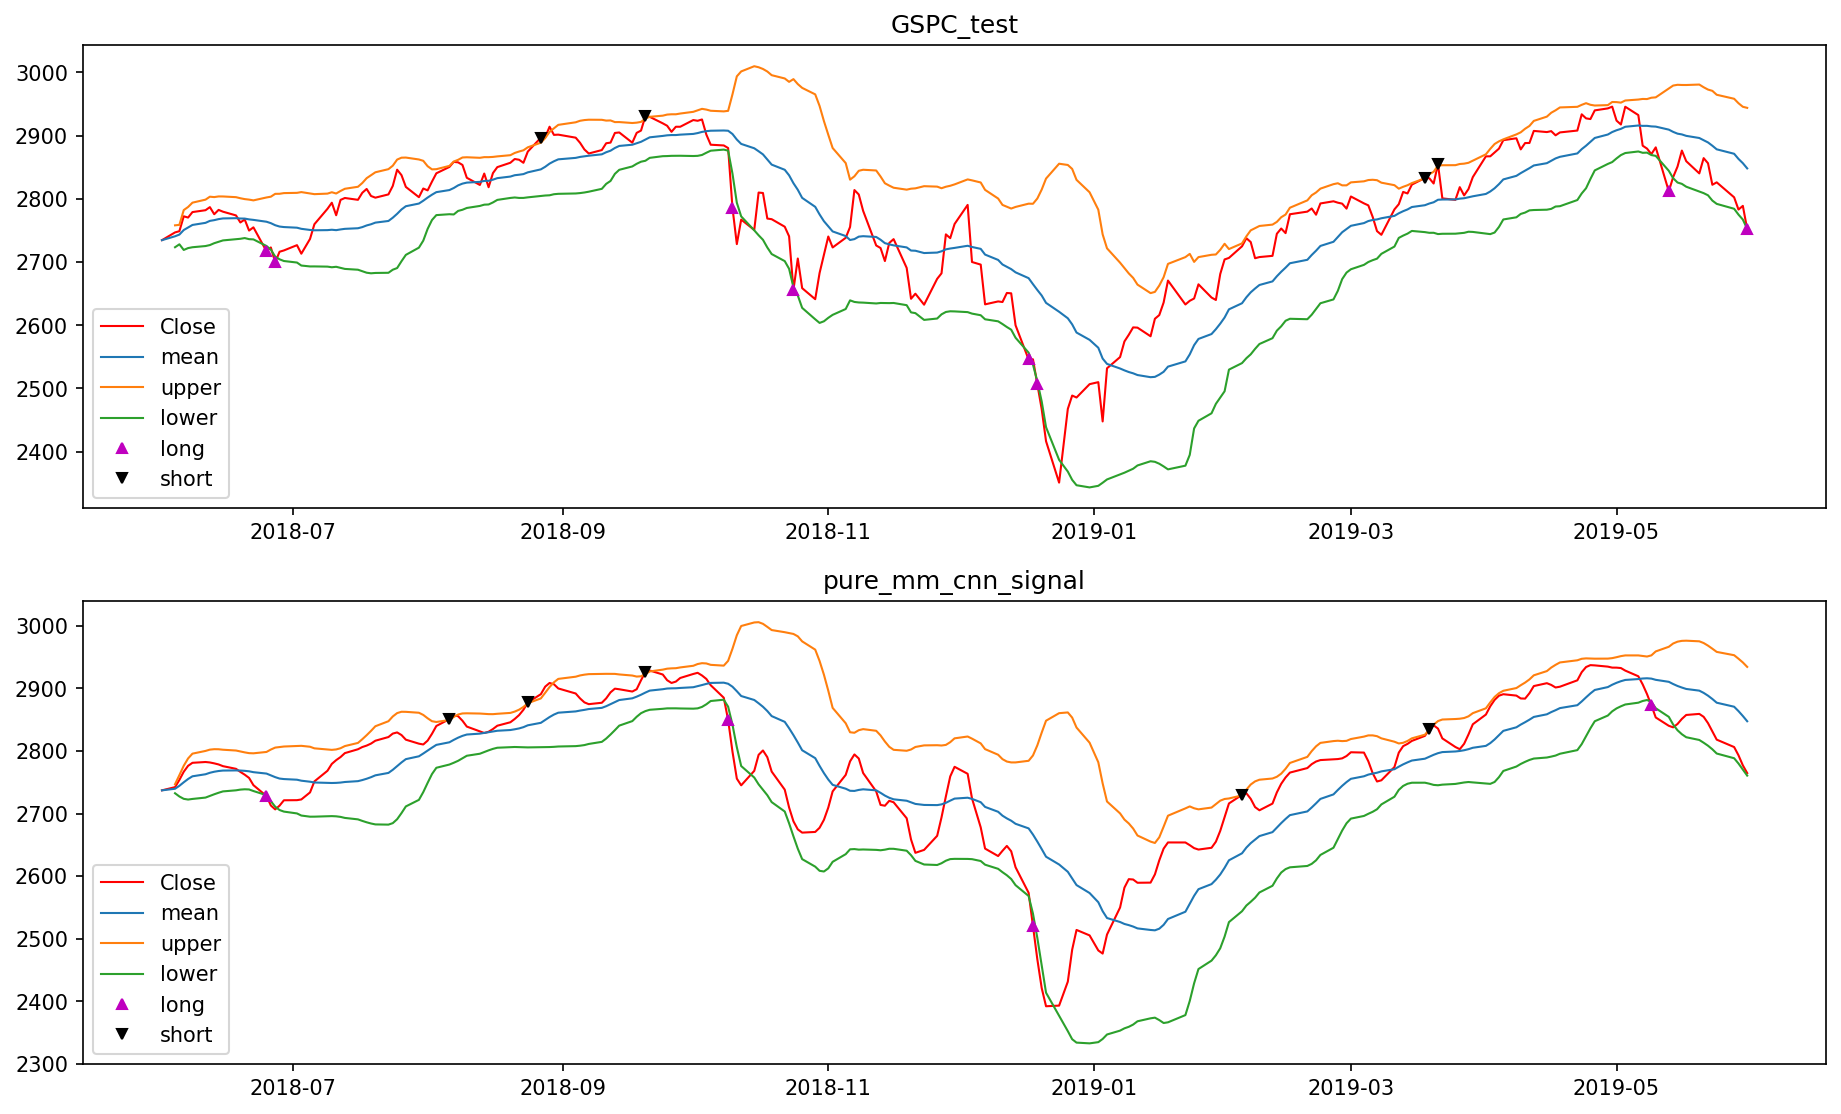

In [82]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [83]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

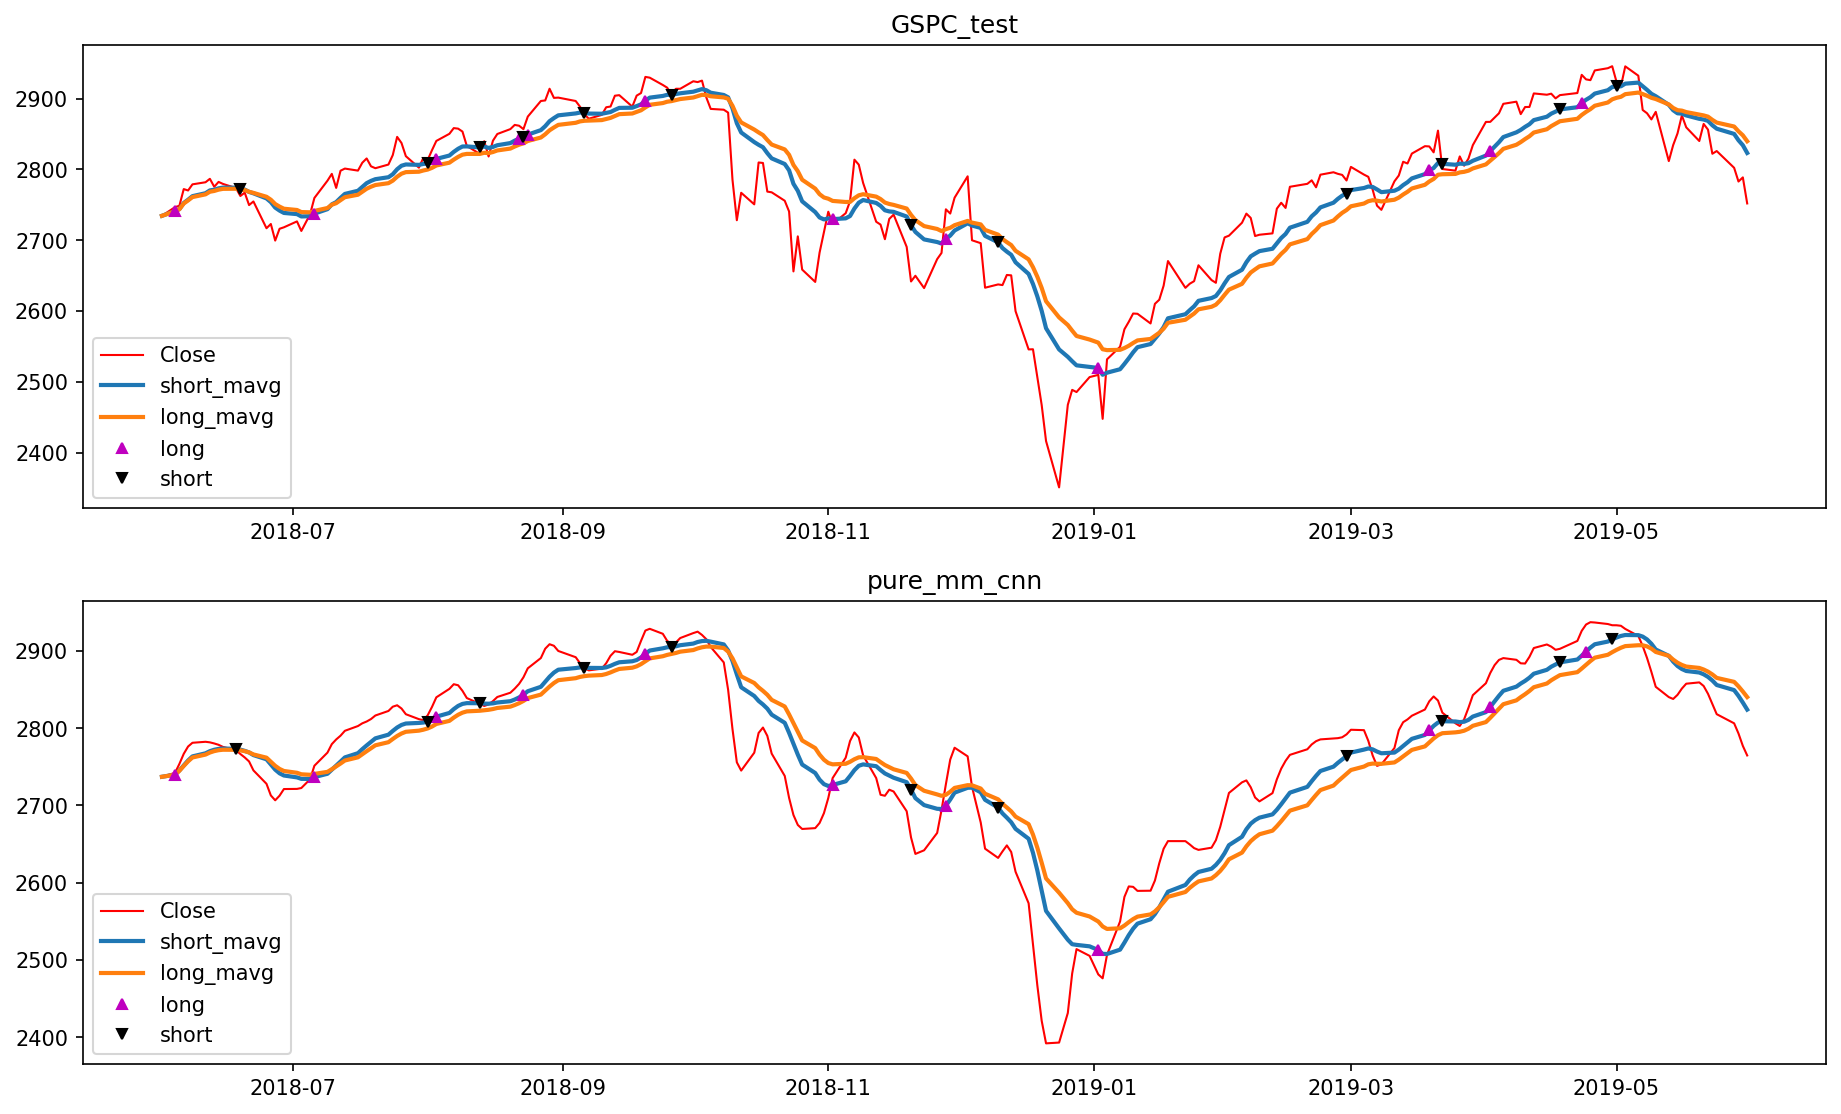

In [84]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [85]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    226
 1.0     12
-1.0     12
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    228
 1.0     11
-1.0     11
Name: positions, dtype: int64 



In [86]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2018-06-04  2746.870117
2018-07-06  2759.820068
2018-08-03  2840.350098
2018-08-22  2861.820068
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-02  2510.030029
2019-03-19  2832.570068
2019-04-02  2867.239990
2019-04-23  2933.679932
              Adj Close
Date                   
2018-06-04  2746.870117
2018-07-06  2759.820068
2018-08-03  2840.350098
2018-08-23  2856.979980
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-02  2510.030029
2019-03-19  2832.570068
2019-04-02  2867.239990
2019-04-24  2927.250000


In [87]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2018-06-19  2762.590088
2018-08-01  2813.360107
2018-08-13  2821.929932
2018-08-23  2856.979980
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-28  2784.489990
2019-03-22  2800.709961
2019-04-18  2905.030029
2019-05-01  2923.729980
              Adj Close
Date                   
2018-06-18  2773.750000
2018-08-01  2813.360107
2018-08-13  2821.929932
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-28  2784.489990
2019-03-22  2800.709961
2019-04-18  2905.030029
2019-04-30  2945.830078


## MA

In [88]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

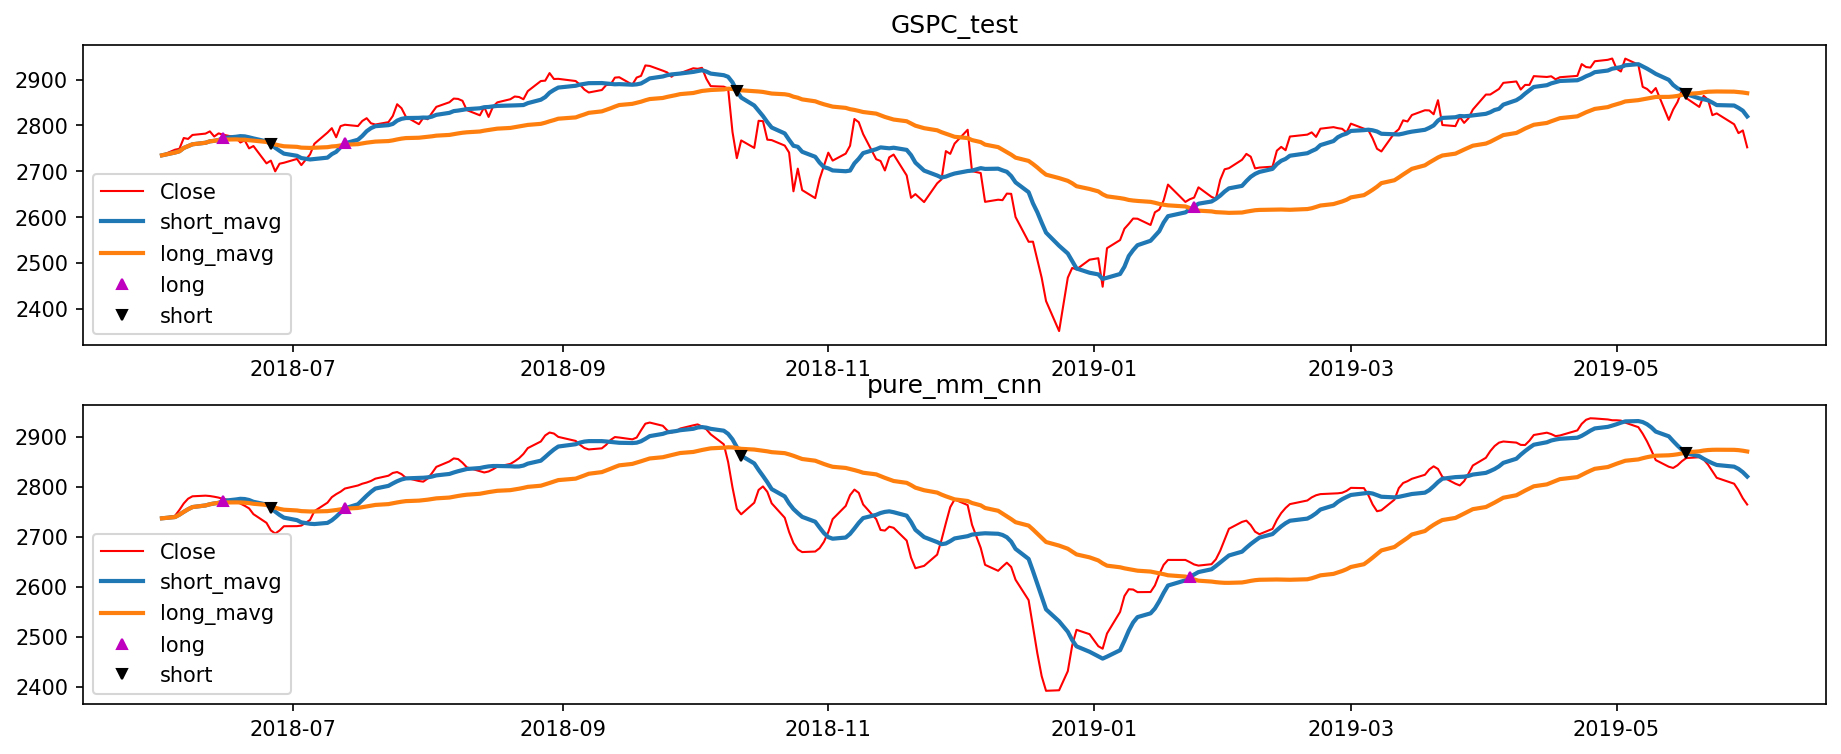

In [89]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [90]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    244
 1.0      3
-1.0      3
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    244
 1.0      3
-1.0      3
Name: positions, dtype: int64 



In [91]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2018-06-15  2779.659912
2018-07-13  2801.310059
2019-01-24  2642.330078
              Adj Close
Date                   
2018-06-15  2779.659912
2018-07-13  2801.310059
2019-01-23  2638.699951


In [92]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2018-06-26  2723.060059
2018-10-11  2728.370117
2019-05-17  2859.530029
              Adj Close
Date                   
2018-06-26  2723.060059
2018-10-12  2767.129883
2019-05-17  2859.530029


## Strategies backtest

In [93]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [94]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [95]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [96]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.03263379541015625
0.048575579833984375


In [97]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
#print(mareturn_lstm)

0.04291489184570312
0.06535189624023438


In [98]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)


0.061144982421875
-0.048463360107421874
